<h4> Introduction: </h4>
<p> Project aims to classify messages spam/not spam using <b> word2vec model trained by spam.csv </b> and  supervised machine learning algorithms such as SVC, LogisticRegression and KNearestNeighbor</p>
<p> Finally, compute and compare the accuracy score of three models </p>

<h4> Import Libraries </h4>

In [118]:
"""
ignore warning come out from functions
"""
import warnings
warnings.filterwarnings("ignore")

"""
Data tools
"""
import numpy as np
import pandas as pd
import os, sys

"""
NLP tools
"""
import nltk
import gensim
import gensim.models
from gensim.models import KeyedVectors
from gensim.models.keyedvectors import KeyedVectors
from gensim.models import Word2Vec

"""
supervised classifiers
"""
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score

"""
Libraries for accessory functions
"""
import pickle
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
import string
import re
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer

"""
Plot result
"""
import matplotlib.pyplot as plt


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\btdiem\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\btdiem\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\btdiem\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\btdiem\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


<h4> Accessory Functions </h4>

In [119]:
def write_pickle(file_name, data):      
    """
    Function writes serialised object
    
    Arg:
     - file_name: path + file name. for example: data/google_model.pkl
     - data: pickle object
    """
    output = open(file_name, 'wb')
    # Pickle dictionary using protocol 0.
    pickle.dump(data, output)
    
    output.close()

def read_pickle(file_name):
    """
    Function reads pickle file
    
    Arg:
        - file_name: path + pickle file name , for example:C:/data/google_model.pkl
    """
    pkl_file = open(file_name, 'rb')

    google_model = pickle.load(pkl_file)

    pkl_file.close()
    

def tokenizer(w2vec_model, doc):
    """
    Function tokenizes doc and return vector of words found in w2vec_model
    
    Arg:
        - w2vec_model: a gensim word2vec model
        - doc: a string, for example: 'Using NLP to gain insights from employee review data'
    
    Return:
        A list of words in w2vec_model
    
    """
    vector = []
    tokens = doc.split(' ')
    for w in tokens:
        if w in w2vec_model.vocab.keys():
            vector.append(w)

    return vector


def get_doc_vec(words, w2vec_model):
    """
    Function to take a document as a list of words and return the document vector
    
    Arg:
        - words: a list of words, for example: ["w1", "w2", "w3"]
        - w2vec_model: vector of vocabularies
        
    """

    good_words = []
    for word in words:
        # Words not in the original model will fair
        try:
            if word in w2vec_model:
                good_words.append(word)
        except:
            continue
    # If no words are in the original model
    # print("good_words: {}".format(good_words))
    if len(good_words) == 0:
        return None
    # Return the mean of the vectors for all the good words
    return w2vec_model[good_words].mean(axis=0)


def get_wordnet_pos(treebank_tag):
    """
    Convert the part-of-speech naming scheme
    from the nltk default to that which is
    recognized by the WordNet lemmatizer
    
    """

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

    
def preprocess_series_text(data):
    """
    Perform complete preprocessing on a Pandas series
    including removal of alpha numerical words, normalization,
    punctuation removal, tokenization, stop word removal, 
    and lemmatization.
       
    Arg:
        data: pandas series 
    
    Return:
        processed pandas series
    """
    
    # remove alpha numerical words and make lowercase
    alphanum_re = re.compile(r"""\w*\d\w*""")
    alphanum_lambda = lambda x: alphanum_re.sub('', x.strip().lower())

    data = data.map(alphanum_lambda)

    # remove punctuation
    punc_re = re.compile('[%s]' % re.escape(string.punctuation))
    punc_lambda = lambda x: punc_re.sub(' ', x)

    data = data.map(punc_lambda)

    # tokenize words
    data = data.map(word_tokenize)

    # remove stop words
    sw = stopwords.words('english')
    sw_lambda = lambda x: list(filter(lambda y: y not in sw, x))

    data = data.map(sw_lambda)

    # part of speech tagging--must convert to format used by lemmatizer
    data = data.map(nltk.pos_tag)
    pos_lambda = lambda x: [(y[0], get_wordnet_pos(y[1])) for y in x]
    data = data.map(pos_lambda)

    # lemmatization
    lemmatizer = WordNetLemmatizer()
    lem_lambda = lambda x: [lemmatizer.lemmatize(*y) for y in x]
    data = data.map(lem_lambda)
    
    return data.map(' '.join)

def get_mean_score(clf, cv=10):
    """
    Get the scores from classifier and return the mean value
    
    Arg:
     - clf: classifier, for ex: LogisticRegression, SVC,..
     - cv : cross validation parameter
     
    Return:
        mean of scores
    """
    scores = cross_val_score(clf, X, y , cv=10)
    
    return np.mean(scores)

#### Train Word2Vec Vectors Model with spam.csv: 
* Read the spam dataset into a Dataframe.
* Preprocess the documents using <code> preprocess_series_text(data) </code>.
* Split each document into a list of words.
* Use the results to train your own word2vec model with `gensim`.


In [120]:
# Read spam_csv and print out first 5 rows

spam_data = pd.read_csv('data/spam.csv', sep='\t', 
                        header=None, names=["label", "text"])                         

spam_data.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [121]:
#preprocess data

spam_data['text'] = preprocess_series_text(spam_data['text'])

In [122]:
# Split each document into a list of words.
sentences = spam_data['text'].str.split()

sentences[:5]

0    [go, jurong, point, crazy, available, bugis, n...
1                       [ok, lar, joking, wif, u, oni]
2    [free, entry, wkly, comp, win, fa, cup, final,...
3        [u, dun, say, early, hor, u, c, already, say]
4          [nah, think, go, usf, life, around, though]
Name: text, dtype: object

In [123]:
# Train word2vec with spam data
spam_w2vec_model = Word2Vec(sentences)

<p> Check out some conceptual comparisons with our word2vec model. </p>

In [124]:
spam_w2vec_model.most_similar('call')

[('free', 0.9998507499694824),
 ('mobile', 0.9998424053192139),
 ('number', 0.9998326897621155),
 ('line', 0.9997907876968384),
 ('voucher', 0.9997876286506653),
 ('week', 0.9997807741165161),
 ('customer', 0.9997776746749878),
 ('text', 0.9997731447219849),
 ('receive', 0.9997721910476685),
 ('urgent', 0.9997670650482178)]

In [125]:
spam_w2vec_model.most_similar('win')

[('holiday', 0.9999002814292908),
 ('voucher', 0.9998716115951538),
 ('ur', 0.9998674392700195),
 ('c', 0.9998595118522644),
 ('word', 0.9998503923416138),
 ('week', 0.999850332736969),
 ('collect', 0.9998490810394287),
 ('msg', 0.9998487234115601),
 ('play', 0.9998477101325989),
 ('per', 0.9998436570167542)]

<p> From Word2Vec we have vectors for words,  How do we get vectors for whole documents? </p>
<p> We have to make vector of document from word vector</p>

In [126]:
spam_vecs = spam_data.text.str.split().map(lambda x: get_doc_vec(x, spam_w2vec_model))
spam_vecs[:5]

0    [0.1444864, 0.25257498, 0.05145365, -0.0599798...
1    [0.15285298, 0.2741392, 0.057334818, -0.064060...
2    [0.13937083, 0.23683971, 0.04580003, -0.052127...
3    [0.1979268, 0.35462674, 0.074506976, -0.083067...
4    [0.15175353, 0.2638947, 0.053968746, -0.061849...
Name: text, dtype: object

<p>Add <code> spam_vecs </code> as new feature to <code> spam_data </code> </p>

In [127]:
spam_data['vecs'] = spam_vecs

spam_data.head()

,label,text,vecs
0,ham,go jurong point crazy available bugis n great ...,"[0.1444864, 0.25257498, 0.05145365, -0.0599798..."
1,ham,ok lar joking wif u oni,"[0.15285298, 0.2741392, 0.057334818, -0.064060..."
2,spam,free entry wkly comp win fa cup final tkts may...,"[0.13937083, 0.23683971, 0.04580003, -0.052127..."
3,ham,u dun say early hor u c already say,"[0.1979268, 0.35462674, 0.074506976, -0.083067..."
4,ham,nah think go usf life around though,"[0.15175353, 0.2638947, 0.053968746, -0.061849..."


<p> Some of the documents have no good words in them. Let's drop them from our dataset </p>

In [128]:
spam_data = spam_data.dropna()

spam_data.shape


(5517, 3)

<p> What is the length of vector ?</p>

In [129]:
len(spam_data.vecs[:1].values[0])

100

In [130]:
#Lenght of vector
len_vec = len(spam_data.vecs[:1].values[0])
# Create a Numpy array of the document vectors
spam_np_vecs = np.zeros((len(spam_data), len_vec))
for i, vec in enumerate(spam_data.vecs):
    spam_np_vecs[i, :] = vec
    
# Combine the full dataframe with the labels
spam_w2v_data = pd.concat([spam_data.reset_index().label, pd.DataFrame(spam_np_vecs)], axis=1)

spam_w2v_data.head()

,label,0,1,2,3,4,5,6,7,8,...,90,91,92,93,94,95,96,97,98,99
0,ham,0.144486,0.252575,0.051454,-0.059980,-0.033501,-0.069658,0.217711,-0.395451,0.125066,...,0.305336,0.243675,-0.046680,0.089231,-0.178807,-0.211533,-0.128441,0.034884,0.055130,-0.654755
1,ham,0.152853,0.274139,0.057335,-0.064060,-0.034944,-0.077309,0.235172,-0.432041,0.138651,...,0.330311,0.263969,-0.052178,0.097975,-0.193324,-0.231282,-0.137487,0.037318,0.060486,-0.711483
2,spam,0.139371,0.236840,0.045800,-0.052128,-0.034396,-0.060149,0.208590,-0.376427,0.119853,...,0.287832,0.222790,-0.046136,0.083759,-0.172661,-0.200625,-0.125590,0.027405,0.050847,-0.632499
3,ham,0.197927,0.354627,0.074507,-0.083068,-0.045381,-0.103098,0.300230,-0.553187,0.175941,...,0.424584,0.334762,-0.063873,0.124478,-0.249485,-0.299436,-0.179657,0.046965,0.075864,-0.915028
4,ham,0.151754,0.263895,0.053969,-0.061849,-0.033135,-0.076426,0.227409,-0.410801,0.132604,...,0.315791,0.255154,-0.049716,0.092760,-0.186815,-0.221754,-0.133469,0.034608,0.058734,-0.681842


<p> Everything seems familiar now. We have training data and label data</p>
<p> We shall transform label column to numeric values <code> (1: spam, 0: ham) </code> so that machine can understand </p>

In [131]:
spam_w2v_data['label'] = np.where(spam_w2v_data['label']=='spam', 1, 0)

spam_w2v_data.head()

,label,0,1,2,3,4,5,6,7,8,...,90,91,92,93,94,95,96,97,98,99
0,0,0.144486,0.252575,0.051454,-0.059980,-0.033501,-0.069658,0.217711,-0.395451,0.125066,...,0.305336,0.243675,-0.046680,0.089231,-0.178807,-0.211533,-0.128441,0.034884,0.055130,-0.654755
1,0,0.152853,0.274139,0.057335,-0.064060,-0.034944,-0.077309,0.235172,-0.432041,0.138651,...,0.330311,0.263969,-0.052178,0.097975,-0.193324,-0.231282,-0.137487,0.037318,0.060486,-0.711483
2,1,0.139371,0.236840,0.045800,-0.052128,-0.034396,-0.060149,0.208590,-0.376427,0.119853,...,0.287832,0.222790,-0.046136,0.083759,-0.172661,-0.200625,-0.125590,0.027405,0.050847,-0.632499
3,0,0.197927,0.354627,0.074507,-0.083068,-0.045381,-0.103098,0.300230,-0.553187,0.175941,...,0.424584,0.334762,-0.063873,0.124478,-0.249485,-0.299436,-0.179657,0.046965,0.075864,-0.915028
4,0,0.151754,0.263895,0.053969,-0.061849,-0.033135,-0.076426,0.227409,-0.410801,0.132604,...,0.315791,0.255154,-0.049716,0.092760,-0.186815,-0.221754,-0.133469,0.034608,0.058734,-0.681842


<h4> Spam Classification with Word2Vec </h4>
<p>Try with LogisticRegression, KNeighborsClassifier (n_neighbors=100) and SVC(C=100000) with cross validation cv=10</p>

In [132]:
y = spam_w2v_data['label']

X = spam_w2v_data.drop(['label'], axis=1)



   LogisticRegression  KNeighbors      SVC
0            0.958857    0.899401  0.96701


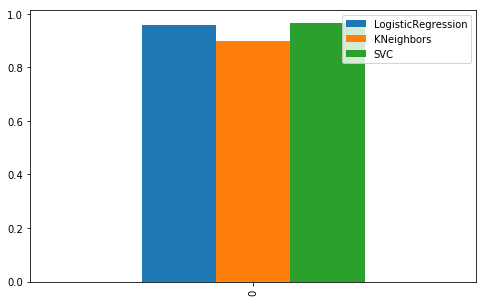

In [136]:
result = {}

classifiers = {"LogisticRegression" : LogisticRegression(C=1000000)
              , "KNeighbors" : KNeighborsClassifier(n_neighbors=100)
              , 'SVC' : SVC(C=100000)}

p_cv = 10

for (clf_name, clf) in classifiers.items():
    score =  get_mean_score(clf, cv = p_cv)
    result.update({clf_name: [score]})


df = pd.DataFrame(result)
print(df)

df.plot(kind='bar', figsize=(8, 5))
plt.show()



<p><b>Conclusion:</b> It seems that Support Vector Machine performs the best among three. LogisticRegression takes the second position and KNeighborsClassifier comes the last </p>